# Bathymetric particle filter 

This notebook is a testing and development environment for the geophysical particle filter. As of 30 December 2024 the initial implementation will be a velocity-state based implementation that does not do the proposed full state mechanization. The full state mechanization will be implemented in the future under a ROS2 and Gazebo simulation environment that allows for more realistic (and reliable) IMU simulation.

In [5]:
from src.data_management import m77t as tbx
import os       
import pandas as pd
import numpy as np
from numpy.typing import NDArray
from numpy import float64, int64, sin, cos, tan, rad2deg, deg2rad, eye
from matplotlib import pyplot as plt
from pyins import strapdown, transform, measurements, filters, sim, earth, util
from numpy.random import multivariate_normal as mvn
from src.geophysical import gmt_toolbox as gmt
from anglewrapper import wrap
from haversine import haversine, haversine_vector, Unit

In [6]:
home = os.path.join("~/Code/research_workspace")
datapath = os.path.join(home, "source_data", "marine_tracklines")
outpath = os.path.join(home, "source_data", "db")
filepath = os.path.join("test", "test_data.m77t")

In [7]:
datain = tbx.process_m77t_file(filepath)
traj = datain[2].copy()
traj_ins = traj.copy()
traj_ins.index = traj.index.to_series().diff().dt.total_seconds().fillna(0).cumsum()

increments = strapdown.compute_increments_from_imu(traj_ins, "rate")
#increments = increments.rolling(window=5, min_periods=1).mean()
observations = measurements.Position(sim.generate_position_measurements(traj_ins[["lat", "lon", "alt"]], 5.0), 5.0)
init_pva = traj_ins.loc[
    traj_ins.index[0],
    ["lat", "lon", "alt", "VN", "VE", "VD", "roll", "pitch", "heading"],
]
distance = traj_ins["distance"].to_numpy()

In [8]:
# Run the filter
integrator = strapdown.Integrator(init_pva, True)
integrator.integrate(increments)

feedback = filters.run_feedback_filter(
    init_pva,
    5,
    2,
    1,
    1,
    increments,
    measurements=[observations],
    time_step=1.0,
    with_altitude=True,
)
ins_errors = transform.compute_state_difference(traj_ins, feedback.trajectory)
integrator_error = transform.compute_state_difference(traj_ins, integrator.trajectory)

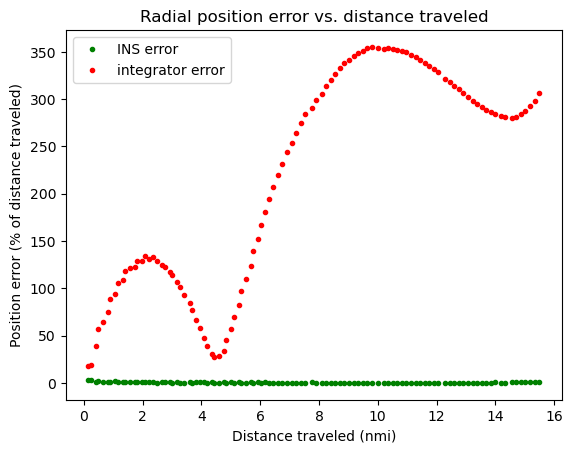

In [9]:
# Plot the results as a function of distance traveled
plt.plot(
    distance / 1852,
    100 * np.sqrt(ins_errors.north**2 + ins_errors.east**2) / distance,
    'g.',
    label="INS error",
)
plt.plot(
    distance / 1852,
    100 * np.sqrt(integrator_error.north**2 + integrator_error.east**2) / distance,
    'r.',
    label="integrator error",
)
plt.xlabel("Distance traveled (nmi)")
plt.ylabel("Position error (% of distance traveled)")
plt.title("Radial position error vs. distance traveled")
plt.legend()
plt.show()

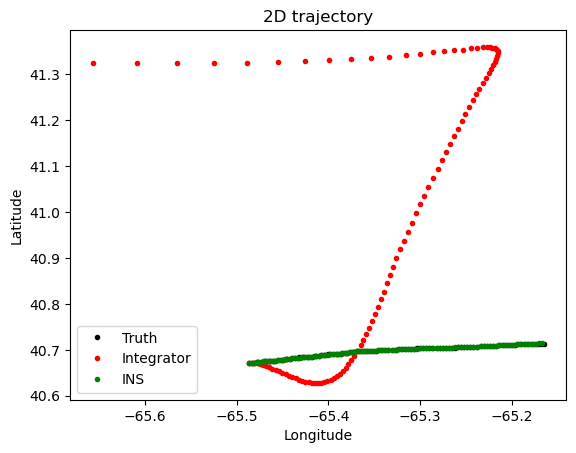

In [10]:
plt.plot(traj_ins.lon, traj_ins.lat, 'k.', label="Truth")
plt.plot(integrator.trajectory.lon, integrator.trajectory.lat, 'r.', label="Integrator")
plt.plot(feedback.trajectory.lon, feedback.trajectory.lat, 'g.', label="INS")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("2D trajectory")
plt.legend()
plt.show()

## Particle Filter Mechanization

The whole goal of this exercise is to recreate an actual truth since I do not have access to proper inertial trajectories and had to simulate IMU values. PyINS can do the basic classical INS-GNSS integration. That will serve as my calculated truth value. The particle filter will then try to estimate the position and/or velocity of the system using the simulated IMU values. For starters, we should try to recreate the integration method used in PyINS so that the same strapdown mechanization can be used in the particle filter and does not inject a source of error into the system. As such we should try to have the resulting strapdown mechanization produce the same results as in `integrator` above.

For some reason, PyINS strapdown mechanization does not behave as expected in predict mode. So subclassing the `Integrator` class is probably out. One possible source of prior errors was not using the coning and sculling corrections. I will evaluate that.

In [8]:
from src.geophysical import particle_filter as pf

## Basic Groves NED Update from velocities

The original particle filter implementation we did with pre-computed and oriented velocities.

In [176]:
def propagate_ned_from_velocities(
    particles: NDArray[float64 | int64],
    velocities: NDArray[float64 | int64],
    dt: float64 | int64,
) -> NDArray:
    """
    Propagate the particles according to the strapdown INS equations using uncorrected velocities. The particles navigation
    states are solely the position and velocity of the vehicle.
    """
    # ======================
    # Notes:
    # 1. This implementation is CORRECT and closely matches the truth data.
    # 2. Prior Groves implementation appears to get the angles and attitude update correct
    # 3. Error appears to be in the velocity update?

    # Getting some constants
    Rn_, Re_, _ = earth.principal_radii(particles[:, 0], particles[:, 2])
    # Prior values
    lat_ = deg2rad(particles[:, 0])
    lon_ = deg2rad(particles[:, 1])
    alt_ = particles[:, 2]
    vn_ = particles[:, 3]
    ve_ = particles[:, 4]
    vd_ = particles[:, 5]
    # Position Update
    alt = alt_ - dt / 2 * (vd_ + velocities[2])
    lat = lat_ + dt / 2 * (vn_ / (Rn_ + lat_) + velocities[0] / (Rn_ + alt))
    # Get new Rn, Re and update longitude
    _, Re, _ = earth.principal_radii(lat, alt)
    lon = lon_ + dt / 2 * (ve_ / ((Re_ + alt_) * cos(lat_)) + velocities[1] / ((Re + alt) * cos(lat)))

    return np.concat([rad2deg(lat), rad2deg(lon), alt, velocities])

## Savage's Strapdown Mechanization

This is an attempt to recreate the `integrate` method from `_numba_integrate`. So far unsuccessful.

In [177]:
import numpy as np

# Constants for unit conversion
DEG_TO_RAD = np.pi / 180
RAD_TO_DEG = 180 / np.pi

def gravity(lat, alt):
    sin2 = np.sin(lat * DEG_TO_RAD) ** 2
    return (earth.GE * (1 + earth.F * sin2) /
            (1 - earth.E2 * sin2) ** 0.5 * (1 - 2 * alt / earth.A))

def mat_from_rotvec(rv):
    """
    Generate a rotation matrix from a rotation vector (small angle approximation).
    """
    norm2 = np.sum(rv**2)
    if norm2 > 1e-6:
        norm = np.sqrt(norm2)
        cos = np.cos(norm)
        k1 = np.sin(norm) / norm
        k2 = (1 - cos) / norm2
    else:
        cos = 1 - norm2 / 2
        k1 = 1 - norm2 / 6
        k2 = 0.5 - norm2 / 24

    rvx, rvy, rvz = rv
    mat = np.zeros((3, 3))
    mat[0, 0] += k2 * rvx * rvx
    mat[0, 1] += k2 * rvx * rvy - k1 * rvz
    mat[0, 2] += k2 * rvx * rvz + k1 * rvy
    mat[1, 0] += k2 * rvy * rvx + k1 * rvz
    mat[1, 1] += k2 * rvy * rvy
    mat[1, 2] += k2 * rvy * rvz - k1 * rvx
    mat[2, 0] += k2 * rvz * rvx - k1 * rvy
    mat[2, 1] += k2 * rvz * rvy + k1 * rvx
    mat[2, 2] += k2 * rvz * rvz

    return mat

def integrate_savage(dt, state, theta, dv):
    """
    Perform a single strapdown integration update.
    
    Args:
        dt (float): Time step (seconds).
        state (array): State array containing:
                       [latitude (deg), longitude (deg), altitude (m),
                        velocity_north (m/s), velocity_east (m/s), velocity_down (m/s),
                        orientation (3x3 DCM)].
        theta (array): Gyroscope measurements [p, q, r] (rad/s).
        dv (array): Accelerometer measurements [ax, ay, az] (m/s^2).
        
    Returns:
        Updated state array.
    """
    # Initialize some variables
    xi = np.empty(3)
    dv_n = np.empty(3)
    C = np.empty((3, 3))
    dBn = np.empty((3, 3))
    dBb = np.empty((3, 3))

    # Extract the state components
    lat, lon, alt, vn, ve, vd, roll, pitch, yaw = state

    sin_lat = np.sin(lat * transform.DEG_TO_RAD)
    cos_lat = np.sqrt(1 - sin_lat * sin_lat)
    tan_lat = sin_lat / cos_lat

    x = 1 - earth.E2 * sin_lat * sin_lat
    re = earth.A / x ** 0.5
    rn = re * (1 - earth.E2) / x + alt
    re += alt

    Omega1 = earth.RATE * cos_lat
    Omega2 = 0.0
    Omega3 = -earth.RATE * sin_lat

    V1 = vn
    V2 = ve
    V3 = vd

    rho1 = V2 / re
    rho2 = -V1 / rn
    rho3 = -rho1 * tan_lat
    chi1 = Omega1 + rho1
    chi2 = Omega2 + rho2
    chi3 = Omega3 + rho3

    # Compute the rotation matrix
    mat_nb = mat_from_rotvec(np.array(state[6:9]))
    # update the velocity
    dv_n = mat_nb @ dv
    velocity_n = np.empty(3)
    velocity_n[0] = vn + dv_n[0] + (-(chi2 + Omega2)*V3 + (chi3 + Omega3)*V2 - 0.5 * (chi2*dv_n[2] - chi3*dv_n[1])) * dt
    velocity_n[1] = ve + dv_n[1] + (-(chi3 + Omega3)*V1 + (chi1 + Omega1)*V3 - 0.5 * (chi3*dv_n[0] - chi1*dv_n[2])) * dt
    velocity_n[2] = vd + dv_n[2] + (-(chi1 + Omega1)*V2 + (chi2 + Omega2)*V1 - 0.5 * (chi1*dv_n[1] - chi2*dv_n[0]) + gravity(lat, alt - 0.5*V3*dt)) * dt
    
    V1 = 0.5 * (V1 + velocity_n[0])
    V2 = 0.5 * (V2 + velocity_n[1])
    V3 = 0.5 * (V3 + velocity_n[2])
    rho1 = V2 / re
    rho2 = -V1 / rn
    rho3 = -rho1 * tan_lat
    chi1 = Omega1 + rho1
    chi2 = Omega2 + rho2
    chi3 = Omega3 + rho3

    # Update the position
    lat = lat - transform.RAD_TO_DEG * rho2 * dt
    lon = lon - transform.RAD_TO_DEG * rho1 * dt / cos_lat
    alt = alt - V3 * dt

    # Update the orientation
    xi[0] = -chi1 * dt
    xi[1] = -chi2 * dt
    xi[2] = -chi3 * dt
    dBn = mat_from_rotvec(xi)
    dBb = mat_from_rotvec(theta)
    C = mat_nb @ dBb
    C = dBn @ C

    roll, pitch, yaw = transform.mat_to_rph(C)
    return np.array([lat, lon, alt, velocity_n[0], velocity_n[1], velocity_n[2], roll, pitch, yaw])


## Alternative implmentation of Groves 

This implementation follows the same scheme as groves but without the direction-cosine matrix formulation for orientation. Further this implementation breaks out the individual update sections so that they can be independently tested.

In [297]:
C = transform.mat_from_rph(particles[:, 6:9])
Omega_ie = earth.rate_n(particles[:, 0])
Omega_ie = pf.vector_to_skew_symmetric(Omega_ie)
omega_en = get_transport_rate(particles[:, 0], 
                                particles[:, 2], 
                                particles[:, 3], 
                                particles[:, 4], 
                                particles[:, 5])
Omega_en = pf.vector_to_skew_symmetric(omega_en)

In [309]:
gyro = gyros.to_numpy()
Omega_ib = pf.vector_to_skew_symmetric(gyro)
Omega_ib = np.tile(Omega_ib, (len(particles), 1,1))

In [310]:
I = np.tile(np.eye(3), (len(particles), 1, 1))

In [312]:
C_ = C @ (I + Omega_ib * 1) - (Omega_ie + Omega_en) @ C

In [352]:
def integrate_groves(
    particles: NDArray[float64 | int64],
    gyros: NDArray[float64 | int64],
    accels: NDArray[float64 | int64],
    dt: float64 | int64,
) -> NDArray:
    """
    Integrate the particles using the strapdown INS equations.
    """
    C = transform.mat_from_rph(particles[:, 6:9])
    C_ = attitude_update(particles, gyros, dt) # issue appears to be here.
    accels = specific_force_transformation(accels, C, C_)
    velocity = velocity_update(particles, accels, dt)
    position = position_update(particles, velocity, dt)
    rph = transform.mat_to_rph(C_)
    return np.hstack([position, velocity, rph])

def attitude_update(particles, gyros, dt):
    """
    Update the attitude of the particles using the strapdown INS equations.
    """
    # Convert angles to DCM
    C = transform.mat_from_rph(particles[:, 6:9])
    Omega_ie = earth.rate_n(particles[:, 0])
    Omega_ie = pf.vector_to_skew_symmetric(Omega_ie)
    omega_en = get_transport_rate(particles[:, 0], 
                                    particles[:, 2], 
                                    particles[:, 3], 
                                    particles[:, 4], 
                                    particles[:, 5])
    Omega_en = pf.vector_to_skew_symmetric(omega_en)
    Omega_ib = pf.vector_to_skew_symmetric(gyro)
    Omega_ib = np.tile(Omega_ib, (len(particles), 1,1))
    I_ = np.tile(np.eye(3), (len(particles), 1, 1))
    return C @ (I_ + Omega_ib * dt) - (Omega_ie + Omega_en) @ C * dt


def get_transport_rate(latitudes, altitudes, velocity_north, velocity_east, velocity_down):
    """
    Compute the transport rate of the particles.
    """
    
    # Compute the transport rate
    lats = np.radians(latitudes)
    # Get the principal radii
    Rn, Re, _ = earth.principal_radii(latitudes, altitudes)
    omega_en = np.zeros((len(lats), 3))
    omega_en[:, 0] = velocity_north / (Rn + velocity_down)
    omega_en[:, 1] = velocity_east / (Re + velocity_down)
    omega_en[:, 2] = -velocity_down * np.tan(lats) / (Re + velocity_down)
    return omega_en

def specific_force_transformation(
        accels: NDArray[float64 | int64], 
        C: NDArray[float64 | int64], 
        C_:NDArray[float64 | int64],
        ) -> NDArray:
    """
    Transform the specific force from the body frame to the navigation frame.
    """
    return (0.5 * (C_ + C) @ accels)

def velocity_update(
        particles: NDArray[float64 | int64],
        accels: NDArray[float64 | int64],
        dt: float64 | int64,
) -> NDArray:
    """
    Velocity update using the strapdown INS equations from Groves.
    """
    #n = len(particles)
    # Extend the accels to the number of particles
    #accels = np.tile(accels, (n, 1))
    lats_ = particles[:, 0]
    alts_ = particles[:, 2]
    # Get the principal radii
    Rn, Re, _ = earth.principal_radii(lats_, alts_)
    # Compute the earth rate
    omega_ie = earth.rate_n(lats_)
    gravity = earth.gravity_n(lats_, alts_)
    # Compute the transport rate
    omega_en = get_transport_rate(lats_, alts_, particles[:, 3], particles[:, 4], particles[:, 5])
    # Compute the velocity update
    velocity = particles[:, 3:6] + dt * (accels + gravity - (omega_en + 2 * omega_ie) * particles[:, 3:6])
    return velocity

def position_update(
    particles: NDArray[float64 | int64],
    velocities: NDArray[float64 | int64],
    dt: float64 | int64,
) -> NDArray:
    """
    Position update using the strapdown INS equations from Groves.
    """
    # Getting some constants
    Rn_, Re_, _ = earth.principal_radii(particles[:, 0], particles[:, 2])
    # Prior values
    lat_ = deg2rad(particles[:, 0])
    lon_ = deg2rad(particles[:, 1])
    alt_ = particles[:, 2]
    vn_ = particles[:, 3]
    ve_ = particles[:, 4]
    vd_ = particles[:, 5]
    # Position Update
    alt = alt_ - dt / 2 * (vd_ + velocities[:, 2])
    lat = lat_ + dt / 2 * (vn_ / (Rn_ + lat_) + velocities[:, 0] / (Rn_ + alt))
    # Get new Rn, Re and update longitude
    _, Re, _ = earth.principal_radii(lat, alt)
    lon = lon_ + dt / 2 * (ve_ / ((Re_ + alt_) * cos(lat_)) + velocities[:, 1] / ((Re + alt) * cos(lat)))

    return np.vstack([rad2deg(lat), rad2deg(lon), alt]).T

In [353]:
particles = init_pva.to_numpy().reshape(1,9)
particles = np.repeat(particles, 10, axis=0)
pva_groves = np.zeros((len(traj_ins), 9))
a = 0
gyros_ins = traj_ins[["gyro_x", "gyro_y", "gyro_z"]]#.rolling(5,1).mean()
accels_ins = traj_ins[["accel_x", "accel_y", "accel_z"]]#.rolling(5,1).mean()

In [354]:
for i, imu_row in traj_ins.iloc[1:].iterrows():
    pva_groves[a, :] = particles[0, :]
    gyros = gyros_ins.loc[i, :]
    accels = accels_ins.loc[i, :]
    dt = increments.loc[i, "dt"]
    particles = integrate_groves(particles, gyros.to_numpy(), accels.to_numpy(), dt)
    a += 1
    

/tmp/ipykernel_29842/491503044.py:84: RuntimeWarning: overflow encountered in multiply
  velocity = particles[:, 3:6] + dt * (accels + gravity - (omega_en + 2 * omega_ie) * particles[:, 3:6])
/home/james/Code/research_workspace/geophysical_nav/.pixi/envs/dev/lib/python3.12/site-packages/pyins/earth.py:69: RuntimeWarning: invalid value encountered in sin
  sin_lat = np.sin(np.deg2rad(lat))
/tmp/ipykernel_29842/491503044.py:109: RuntimeWarning: invalid value encountered in cos
  lon = lon_ + dt / 2 * (ve_ / ((Re_ + alt_) * cos(lat_)) + velocities[:, 1] / ((Re + alt) * cos(lat)))
/tmp/ipykernel_29842/399230164.py:6: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  particles = integrate_groves(particles, gyros.to_numpy(), accels.to_numpy(), dt)
/home/james/Code/research_workspace/geophysical_nav/.pixi/envs/dev/lib/python3.12/site-packages/pyins/earth.py:205: RuntimeWarning: invalid value encountered in cos
  result[

In [356]:
vels = integrator.trajectory[['VN', 'VE', 'VD']].to_numpy()
pva_ned = np.zeros((len(traj_ins), 6))
pva_ned[0, :] = init_pva[['lat', 'lon', 'alt', 'VN', 'VE', 'VD']].to_numpy().reshape(1,6)
mu = pva_ned[0, :].reshape(1,6)
a = 1
for i, row in traj_ins.iloc[1:].iterrows():
    vels = row[['VN', 'VE', 'VD']].to_numpy()
    dt = increments.loc[i, "dt"]
    mu = propagate_ned_from_velocities(mu, vels, dt).reshape(1,6)
    #print(f"Mu: {mu}")
    pva_ned[a, :] = mu
    a+=1

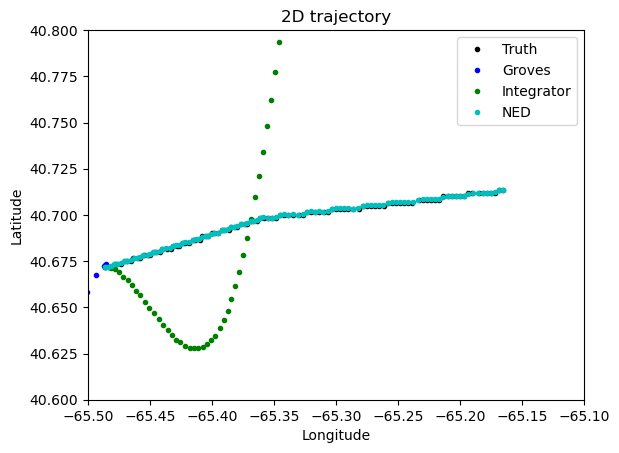

In [357]:
plt.plot(traj_ins.lon, traj_ins.lat, 'k.', label="Truth")
plt.plot(pva_groves[:, 1], pva_groves[:, 0], 'b.', label="Groves")
plt.plot(integrator.trajectory.lon, integrator.trajectory.lat, 'g.', label="Integrator")
plt.plot(pva_ned[:, 1], pva_ned[:, 0], 'c.', label="NED")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.ylim(40.6, 40.8)
plt.xlim(-65.5, -65.1)
#plt.axis("equal")
plt.title("2D trajectory")
plt.legend()
plt.show()

In [358]:
groves_error = haversine_vector(pva_groves[:, :2], traj_ins[['lat', 'lon']].to_numpy(), Unit.METERS)
integrator_error = haversine_vector(integrator.trajectory[['lat', 'lon']].to_numpy(), traj_ins[['lat', 'lon']].to_numpy(), Unit.METERS)
ned_error = haversine_vector(pva_ned[:, :2], traj_ins[['lat', 'lon']].to_numpy(), Unit.METERS)

/home/james/Code/research_workspace/geophysical_nav/.pixi/envs/dev/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:287: RuntimeWarning: invalid value encountered in _haversine_kernel
  return super().__call__(*args, **kws)


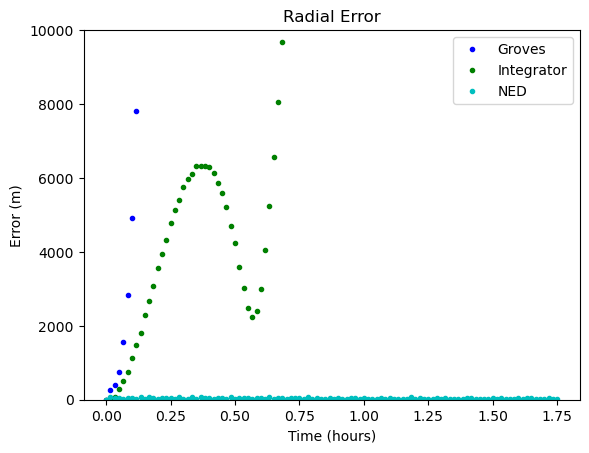

In [359]:
plt.plot(integrator.trajectory.index / 3600, groves_error, 'b.', label="Groves")
plt.plot(integrator.trajectory.index / 3600, integrator_error, 'g.', label="Integrator")
plt.plot(integrator.trajectory.index / 3600, ned_error, 'c.', label="NED")
plt.xlabel("Time (hours)")
plt.ylabel("Error (m)")
plt.title("Radial Error")
plt.ylim(0, 10000)
plt.legend()
plt.show()

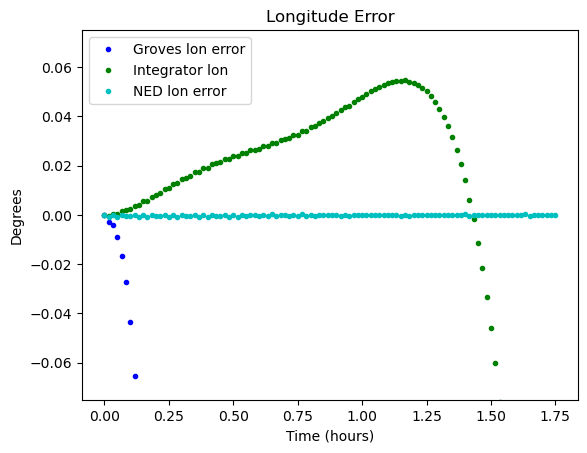

In [360]:
plt.plot(integrator.trajectory.index / 3600, pva_groves[:, 1] - traj_ins.lon, 'b.', label="Groves lon error")
plt.plot(integrator.trajectory.index / 3600, integrator.trajectory.lon  - traj_ins.lon, 'g.', label="Integrator lon")
plt.plot(integrator.trajectory.index / 3600, pva_ned[:, 1] - traj_ins.lon, 'c.', label="NED lon error")
# plt.plot(integrator.trajectory.index, traj_ins.lon, label="Truth lon")
plt.xlabel("Time (hours)")
plt.ylabel("Degrees")
plt.title("Longitude Error")
plt.ylim(-0.075, 0.075)
plt.legend()
plt.show()

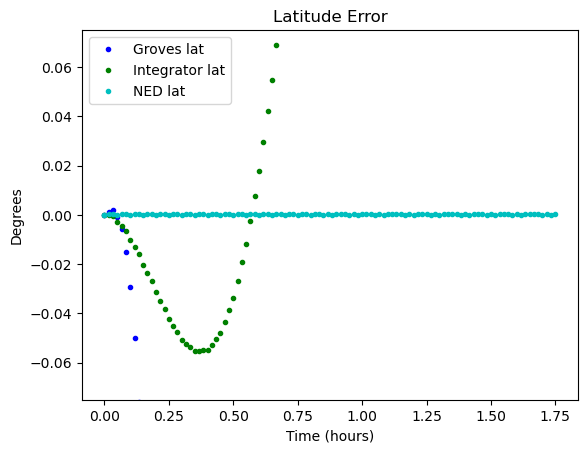

In [361]:
plt.plot(integrator.trajectory.index / 3600, pva_groves[:, 0] - traj_ins.lat, 'b.', label="Groves lat")
plt.plot(integrator.trajectory.index / 3600, integrator.trajectory.lat - traj_ins.lat, '.g', label="Integrator lat")
plt.plot(integrator.trajectory.index / 3600, pva_ned[:, 0] - traj_ins.lat, 'c.', label="NED lat")
plt.ylim(-0.075, 0.075)
plt.xlabel("Time (hours)")
plt.ylabel("Degrees")
plt.title("Latitude Error")
plt.legend()
plt.show()

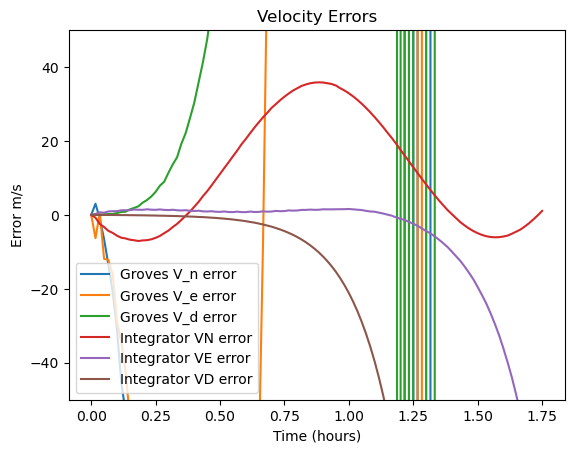

In [362]:
plt.plot(traj_ins.index / 3600, pva_groves[:, 3] - traj_ins["VN"], label="Groves V_n error")
plt.plot(traj_ins.index / 3600, pva_groves[:, 4] - traj_ins["VE"], label="Groves V_e error")
plt.plot(traj_ins.index / 3600, pva_groves[:, 5] - traj_ins["VD"], label="Groves V_d error")

plt.plot(integrator.trajectory.index / 3600, integrator.trajectory.VN - traj_ins["VN"], label="Integrator VN error")
plt.plot(integrator.trajectory.index / 3600, integrator.trajectory.VE - traj_ins["VE"], label="Integrator VE error")
plt.plot(integrator.trajectory.index / 3600, integrator.trajectory.VD - traj_ins["VD"], label="Integrator VD error")

# plt.xlim(0, 1000)
plt.ylim(-50, 50)
plt.xlabel("Time (hours)")
plt.ylabel("Error m/s")
plt.title("Velocity Errors")
plt.legend()
plt.show()

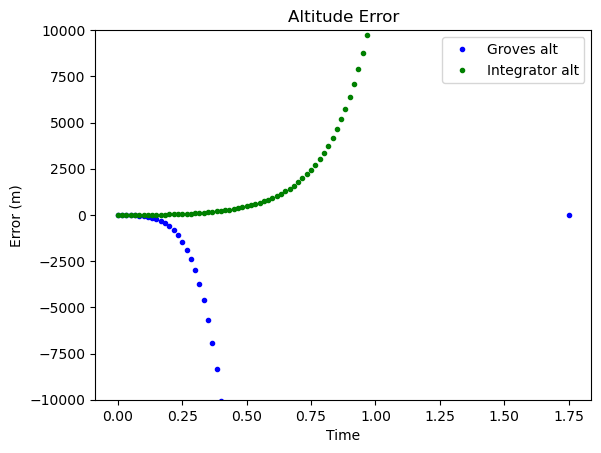

In [363]:
plt.plot(traj_ins.index / 3600, pva_groves[:, 2] - traj_ins.alt, 'b.', label="Groves alt")
plt.plot(integrator.trajectory.index / 3600, integrator.trajectory.alt - traj_ins.alt, 'g.', label="Integrator alt")
plt.xlabel("Time")
plt.ylabel("Error (m)")
plt.ylim(-10000, 10000)
plt.title("Altitude Error")
plt.legend()
plt.show()

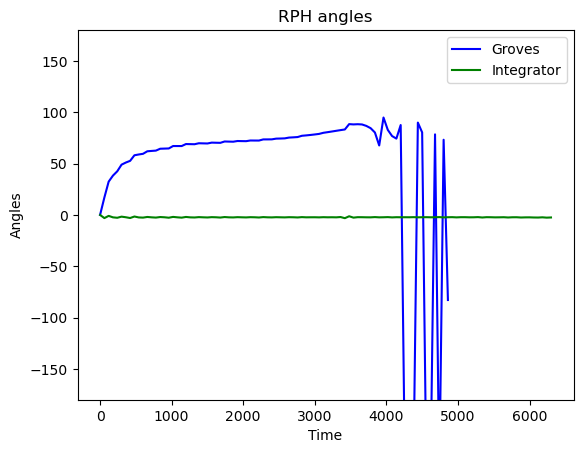

In [364]:
# Plot RPH angles
plt.plot(traj_ins.index, pva_groves[:, 8] - traj_ins["heading"], 'b', label="Groves")
plt.plot(integrator.trajectory.index, integrator.trajectory.heading - traj_ins["heading"], 'g', label="Integrator")
#plt.xlim(0, 1000)#particles[:, 6:9]
plt.ylim(-180, 180)
plt.xlabel("Time")
plt.ylabel("Angles")
plt.title("RPH angles")
plt.legend()
plt.show()

In [ ]:
pva[0, 6:]

In [ ]:
for i, increment in increments.iterrows():
    thetas = increment[["theta_x", "theta_y", "theta_z"]].to_numpy()
    dvs = increment[["dv_x", "dv_y", "dv_z"]].to_numpy()
    particles = particle_filter_propagation(particles, increment["dt"], thetas, dvs)
    lons.append(particles[0, 1])
    lats.append(particles[0, 0])
    alts.append(particles[0, 2])

In [ ]:
plt.plot(north_traj.lon, north_traj.lat, label="Truth")
plt.plot(trajectory_computed.lon, trajectory_computed.lat, label="Integrator")
#plt.plot(lons, lats, label="PF")

plt.legend()
plt.show()

In [ ]:
plt.plot(north_traj.index, north_traj['lon'], label="Truth")
plt.plot(trajectory_computed.index, trajectory_computed['lon'], label="Integrator")
plt.plot(trajectory_computed.index, lons, label="Strapdown")  
plt.title("Longitude")
plt.legend()
plt.show()

In [ ]:
plt.plot(smooth_trajectory.index, smooth_trajectory['lat'], label="Truth")
plt.plot(trajectory_computed.index, trajectory_computed['lat'], label="Integrator")
plt.plot(trajectory_computed.index, lats, label="Strapdown")
plt.title("Latitude")
plt.legend()
plt.show()

In [ ]:
errors = transform.compute_state_difference(trajectory_computed, smooth_trajectory)
plt.plot(smooth_trajectory.index, errors['north'], label="North")
plt.plot(smooth_trajectory.index, errors['east'], label="East")
plt.plot(smooth_trajectory.index, errors['down'], label="Down")
plt.title("Position Errors")
plt.legend()
plt.show()

In [82]:
haversine_error = haversine_vector(trajectory_computed[util.LLA_COLS].to_numpy(),
                                   np.asarray([lons, lats, alts]).T)

In [ ]:
plt.plot(trajectory_computed.index, haversine_error)
plt.title("Haversine Error")
plt.show()

In [ ]:
plt.plot(trajectory_computed.index, trajectory_computed['lon'] - lons, label="Longitude") 
plt.plot(trajectory_computed.index, trajectory_computed['lat'] - lats, label="Latitude")
plt.show()

In [ ]:
plt.plot(integrator.trajectory.index / 3600, integrator.trajectory.lat, label="Integrator")
plt.plot(integrator.trajectory.index[:-1] / 3600, lats, label="Strapdown")
plt.plot(integrator.trajectory.index / 3600, traj_ins.lat, label="Truth")  
#plt.ylim(-100, 100)
plt.title("Latitude")
plt.legend()
plt.show()

In [ ]:
plt.plot(integrator.trajectory.index / 3600, integrator.trajectory.alt, label="Integrator")
plt.plot(integrator.trajectory.index[:-1] / 3600, alts, label="Strapdown")
plt.plot(integrator.trajectory.index / 3600, traj_ins.alt, label="Truth")  
#plt.ylim(-100, 100)
plt.title("Altitude")
plt.legend()
plt.show()

In [ ]:
plt.plot(integrator.trajectory.lon, integrator.trajectory.lat, 'k.', label="Integrator")
plt.plot(traj_ins.lon, traj_ins.lat, 'ro', label="Truth")
plt.plot(lons, lats, 'bx', label="Strapdown")
plt.title("Lats and Lons")
plt.legend()
plt.show()

In [ ]:
traj.head()

In [ ]:
# Initialization parameters
n = 100
dt = 60
i = 10
mu = traj.iloc[i][["lat", "lon", "alt", "VN", "VE", "VD", "roll", "pitch", "heading"]].to_numpy()
mu = np.hstack((mu, np.zeros(6)))
noise = np.array(
    [
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.01,
        0.01,
        0.01,
        0.001,
        0.001,
        0.001,
        0.001,
        0.001,
        0.001,
    ]
)
particles = mvn(mu, np.eye(15), n)

# Coning and sculling with conversions doesn't work (is unneeded) for the PF
# thetas, dvs = coning_and_sculling_correction(current_gyros, previous_gyros, current_accels, previous_accels)

# Getting starting values and inputssix IMU states
gyros = traj.iloc[i][["gyro_x", "gyro_y", "gyro_z"]].to_numpy()  # * dt
accels = traj.iloc[i][["accel_x", "accel_y", "accel_z"]].to_numpy()

propagate_ned(particles, gyros, accels, dt)

# Numba playground

So after doing some research and experimentation I've found two things:

1. Numba functions can only call other jitted functions, not Python functions. So if `foo` is a jitted function that calls `bar`, `bar` must also be a jitted function.
2. Numba really only works well with the foreknowledge that the data is going to be a certain type (numpy array) and known size. Functions like `squeeze` and calls to the `ndarray` class are not supported.

A couple of thoughts and options here:

* Write public wrapper functions that do all the input validations and then call a private jitted function.
* Make use of type annotations and documentation to make it clear what the expected input is. If it breaks that's on the user.

So: for the particle filter implementation, I think I need to go with 

## Simulation parameters verification

First we need to tune the particle filter propagation noise to be similar to that of a marine-grade inertial navigation system. A low-end marine-grade INS should have a drift of 1 nm per 24 hours.

In [ ]:
from src.particle_filter import rmse, propagate
import numpy as np

time = 24 * 60  # minutes
noise = np.array([0, 2.6, 0])
bound = 1852  # meters

errors = []
for v in range(1, 26):
    P = np.asarray([[0, 0, 0, 0, v, 0]])
    T = P.copy()
    t = 0
    for i in range(50000):
        # Eastward
        u = [0, v, 0]
        while t < time:
            P = propagate(P, u, noise=np.diag(noise), noise_calibration_mode=True)
            T = propagate(T, u, noise=np.diag([0, 0, 0]), noise_calibration_mode=False)
            t += 1
        errors.append(rmse(P, T[0, :2]))
        # Northward
        u = [v, 0, 0]
        while t < time:
            P = propagate(P, u, noise=np.diag(noise), noise_calibration_mode=True)
            T = propagate(T, u, noise=np.diag([0, 0, 0]), noise_calibration_mode=False)
            t += 1
        errors.append(rmse(P, T[0, :2]))
        # Northeastward
        u = np.array([1, 1, 0]) / np.linalg.norm([1, 1, 0])
        u *= v
        while t < time:
            P = propagate(P, u, noise=np.diag(noise), noise_calibration_mode=True)
            T = propagate(T, u, noise=np.diag([0, 0, 0]), noise_calibration_mode=False)
            t += 1
        errors.append(rmse(P, T[0, :2]))

print(f"RMSE: {np.mean(errors)}")

In [ ]:
from matplotlib import pyplot as plt

if not os.path.exists(".db/plots"):
    os.makedirs(".db/plots")

plt.hist(errors, bins=15, density=True)
plt.xlabel("RMSE (m)")
plt.ylabel("Frequency")
plt.title("RMSE of Particle Filter")
plt.savefig(".db/plots/propagation_tuning.png")
plt.show()

In [ ]:
config = {"velocity_noise": [noise[1], noise[1], 0]}

## Develop measurement model

Next we need to develop the measurement value standard deviation. We'll first do some general examination of the data. Namely, investigating the sensor measurements to see if we can build a reasonable sensor model.

In [ ]:
from src.gmt_tool import inflate_bounds, get_map_section, get_map_point
import numpy as np
import json

if os.path.exists("config.json"):
    config = json.load(open("config.json", "r"))

tables = pdset.get_tables(".db/parsed.db")
bathy_tables = [table for table in tables if "_D_" in table]

d_bathy = np.array([])

for table in bathy_tables:
    data = pdset.table_to_df(".db/parsed.db", table)
    min_lon = data.LON.min()
    max_lon = data.LON.max()
    min_lat = data.LAT.min()
    max_lat = data.LAT.max()
    min_lon, min_lat, max_lon, max_lat = inflate_bounds(min_lon, min_lat, max_lon, max_lat, 0.25)
    bathy_map = get_map_section(min_lon, max_lon, min_lat, max_lat, "relief", "15s", "temp")
    d_bathy = np.hstack([d_bathy, data["DEPTH"] - (-get_map_point(bathy_map, data.LON, data.LAT))])

config["bathy_mean_d"] = np.mean(d_bathy, where=~np.isnan(d_bathy))
config["bathy_std"] = np.std(d_bathy, where=~np.isnan(d_bathy))

if os.path.exists("config.json"):
    # delete the file
    os.remove("config.json")

with open("config.json", "w") as f:
    json.dump(config, f)

In [ ]:
plt.hist(d_bathy, bins=200, density=True)
plt.xlim([-300, 300])
plt.xlabel("Depth Difference (m)")
plt.ylabel("Frequency")
plt.title("Bathymetry Difference")
plt.savefig(".db/plots/bathy_diff.png")
plt.show()

In [ ]:
config

In [ ]:
import json

with open("config.json", "w") as f:
    json.dump(config, f)

### Populate with velocities

In [ ]:
from src.particle_filter import (
    process_particle_filter,
    populate_velocities,
    plot_error,
    plot_estimate,
    summarize_results,
)
import json
import src.process_dataset as pdset
from tqdm import tqdm
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
tables = pdset.get_tables(".db/parsed.db")
bathy_tables = [table for table in tables if "_D_" in table]
config = json.load(open("config.json", "r"))
config["n"] = 1000
config["cov"] = [
    1 / 60,
    1 / 60,
    0,
    config["velocity_noise"][0],
    config["velocity_noise"][1],
    0,
]

with open("config.json", "w") as f:
    json.dump(config, f)

In [ ]:
config

In [ ]:
df = pdset.table_to_df(".db/parsed.db", bathy_tables[3])

In [ ]:
len(df)

In [ ]:
if not os.path.exists(".db/plots2/estimate/"):
    os.makedirs(".db/plots2/estimate/")

if not os.path.exists(".db/plots2/errors/"):
    os.makedirs(".db/plots2/errors/")

summary = None
annotations = {"recovery": 1852, "res": 1852 / 4}
# for table in tqdm(bathy_tables):
#     print(f"Running {table}")
#     df = pdset.table_to_df(".db/parsed.db", table)

df = populate_velocities(df)
results, geo_map = process_particle_filter(df, config)
print("Run complete! Saving results...")
pdset.save_dataset(
    [results],
    ["test"],
    output_location=".db",
    output_format="db",
    dataset_name="results",
)

In [ ]:
print("Results saved! Plotting...")
fig, ax = plot_estimate(geo_map, results)
fig.savefig(f".db/plots2/estimate/test_estimate.png")
plt.close(fig)
fig, ax = plot_error(results, annotations=annotations)
fig.savefig(f".db/plots2/errors/test_error.png")
plt.close(fig)

In [ ]:
summary = None
results_tables = pdset.get_tables(".db/results.db")
for table in results_tables:
    df = pdset.table_to_df(".db/results.db", table)
    run = summarize_results(df, 1852)
    run["Name"] = table
    if summary is None:
        summary = run  # .copy()
    else:
        summary = pd.concat([summary, run], ignore_index=True)
    summary.to_csv(".db/summary_recovery.csv")

In [ ]:
summary = None
results_tables = pdset.get_tables(".db/results.db")
for table in results_tables:
    df = pdset.table_to_df(".db/results.db", table)
    run = summarize_results(df, 452)
    run["Name"] = table
    if summary is None:
        summary = run  # .copy()
    else:
        summary = pd.concat([summary, run], ignore_index=True)
    summary.to_csv(".db/summary_resolution.csv")

# Data Post Processing

Use this section to load and post process the results data set

In [ ]:
import src.process_dataset as pdset
import pandas as pd
import matplotlib.pyplot as plt
from src.particle_filter import summarize_results
import os
from datetime import timedelta

In [ ]:
results_tables = pdset.get_tables(".db/results.db")
len(results_tables)

In [ ]:
for table in results_tables:
    table_df = pdset.table_to_df(".db/results.db", table)
    summary = summarize_results(table, table_df, 1852)
    summary.to_csv(
        ".db/plots/summary.csv",
        mode="a",
        header=(not os.path.exists(".db/plots/summary.csv")),
    )

In [ ]:
summary = pd.read_csv(
    ".db/plots/summary.csv",
    header=0,
    dtype={
        "": int,
        "name": str,
        "start": str,
        "stop": str,
        "duration": str,
        "average_error": float,
        "max_error": float,
        "min_error": float,
    },
)
summary["num"] = summary["Unnamed: 0"]
summary = summary.drop(columns=["Unnamed: 0"])
# summary['start'] = pd.to_datetime(summary['start'], format="%Y-%m-%d %H:%M:%S%z")
# summary['end'] = pd.to_datetime(summary['end'], format="%Y-%m-%d %H:%M:%S%z")
summary["start"] = pd.to_timedelta(summary["start"])
summary["end"] = pd.to_timedelta(summary["end"])
summary["duration"] = pd.to_timedelta(summary["duration"])
summary.head()

len(summary)

In [ ]:
summary.head()

In [ ]:
recovery = summary.loc[summary["min error"] > 452]
len(recovery)

In [ ]:
# check to see if all the tables in results_tables are present in summary["name"] and if not capture the missing tables
missing = []
for table in results_tables:
    if table not in summary["name"].values:
        missing.append(table)

total = len(results_tables)
num_recoveries = total - len(missing)
print(
    f"There are {total} total trajectories. We were able to recover at least one position fix below drift error in {num_recoveries} ({num_recoveries / total :0.4f}) trajectories."
)

In [ ]:
pixel = summary.loc[summary["min error"] <= 452]

# check to see if the tables in pixel are present in summary["name"] and if not capture the missing tables
missing = []
for table in results_tables:
    if table not in pixel["name"].values:
        missing.append(table)
below_pixel_fixes = total - len(missing)

print(
    f"There are {len(pixel)} total below pixel resolution fixes. We were able to achieve at least one position estimate below drift error in {below_pixel_fixes} ({below_pixel_fixes/total :0.4f}) trajectories."
)
print(f"mean duration: {pixel['duration'].mean()} and median duration: {pixel['duration'].median()}")
print(f"mean error: {pixel['min error'].mean()} and median error: {pixel['min error'].median()}")
print(f"minium duration: {pixel['duration'].min()} and maximum duration: {pixel['duration'].max()}")
print(f"minimum error: {pixel['min error'].min()} and maximum error: {pixel['min error'].max()}")
print(f"mean start: {pixel['start'].mean()} and median start: {pixel['start'].median()}")

In [ ]:
summary.sort_values(by="min error").head(3)

In [ ]:
summary.sort_values(by="start").head(3)

In [ ]:
summary.sort_values(by="duration").tail(3)

In [ ]:
summary.sort_values(by="average_error").head(3)

In [ ]:
# Find the line in summary that has the closest to the mean duration
summary.loc[abs(summary["duration"] - summary["duration"].median()) <= timedelta(minutes=1)]

In [ ]:
summary["duration"].median()

In [ ]:
print(
    f"On average we were able to recover a position fix with an mean duration of {summary['duration'].mean()}, median duration of {summary['duration'].median()} and a mean error of {summary['average_error'].mean()} and median error {summary['average_error'].median()}."
)

print(f"Minimum duration {summary['duration'].min()} and maximum duration {summary['duration'].max()}.")
print(f"Minimum error {summary['average_error'].min()} and maximum error {summary['average_error'].max()}.")

In [ ]:
first = summary.loc[summary["num"] == 0]
# first.head()

print(
    f"The first position recover occurs with a mean of {first['start'].mean()} and median {first['start'].median()} after the start of the trajectory."
)
print(
    f"with an mean duration of {first['duration'].mean()}, median duration of {first['duration'].median()} and a mean error of {first['average_error'].mean()} and median error {first['average_error'].median()}."
)

print(f"Minimum duration {first['duration'].min()} and maximum duration {first['duration'].max()}.")
print(f"Minimum error {first['average_error'].min()} and maximum error {first['average_error'].max()}.")

# Gravity

Recreate the above simulation and measurment model development this time with gravity

In [ ]:
from src.gmt_tool import inflate_bounds, get_map_section, get_map_point
import src.process_dataset as pdset
import numpy as np
import json
from matplotlib import pyplot as plt
import os

config = json.load(open("config.json", "r"))
tables = pdset.get_tables(".db/parsed.db")
gravity_tables = [table for table in tables if "_G_" in table]

In [ ]:
d_gravity = np.array([])

for table in gravity_tables:
    data = pdset.table_to_df(".db/parsed.db", table)
    min_lon = data.LON.min()
    max_lon = data.LON.max()
    min_lat = data.LAT.min()
    max_lat = data.LAT.max()
    min_lon, min_lat, max_lon, max_lat = inflate_bounds(min_lon, min_lat, max_lon, max_lat, 0.25)
    gravity_map = get_map_section(min_lon, max_lon, min_lat, max_lat, "gravity", "01m", "temp")
    d_gravity = np.hstack([d_gravity, data["GRAV_ANOM"] - get_map_point(gravity_map, data.LON, data.LAT)])

config["gravity_mean_d"] = np.mean(d_gravity, where=~np.isnan(d_gravity))
config["gravity_std"] = np.std(d_gravity, where=~np.isnan(d_gravity))

if os.path.exists("config.json"):
    # delete the file
    os.remove("config.json")

with open("config.json", "w") as f:
    json.dump(config, f)

plt.hist(d_gravity, bins=100, density=True)
plt.xlim([-50, 75])
plt.xlabel("Gravity Difference (mGal)")
plt.ylabel("Frequency")
plt.title("Gravity Anomaly Difference")
plt.savefig(".db/plots/gravity_diff.png")
plt.show()

# Magnetics

Recreation with magnetics

In [ ]:
from src.gmt_tool import inflate_bounds, get_map_section, get_map_point
import numpy as np
import json

config = json.load(open("config.json", "r"))
tables = pdset.get_tables(".db/parsed.db")
mag_tables = [table for table in tables if "_M_" in table]

df = pdset.table_to_df(".db/parsed.db", mag_tables[0])
df.head()

In [ ]:
d_magnetics = np.array([])

for table in mag_tables:
    data = pdset.table_to_df(".db/parsed.db", table)
    min_lon = data.LON.min()
    max_lon = data.LON.max()
    min_lat = data.LAT.min()
    max_lat = data.LAT.max()
    min_lon, min_lat, max_lon, max_lat = inflate_bounds(min_lon, min_lat, max_lon, max_lat, 0.25)
    mag_map = get_map_section(min_lon, max_lon, min_lat, max_lat, "magnetic", "02m", "temp")
    d_magnetics = np.hstack([d_magnetics, data["MAG_RES"] - get_map_point(mag_map, data.LON, data.LAT)])

config["magnetic_mean_d"] = np.mean(d_magnetics, where=~np.isnan(d_magnetics))
config["magnetic_std"] = np.std(d_magnetics, where=~np.isnan(d_magnetics))

if os.path.exists("config.json"):
    # delete the file
    os.remove("config.json")

with open("config.json", "w") as f:
    json.dump(config, f)

In [ ]:
plt.hist(d_magnetics, bins=100, density=True)
plt.xlim([-500, 500])
plt.xlabel("Magnetic Difference (nT)")
plt.ylabel("Frequency")
plt.title("Magnetic Residual Difference")
plt.savefig(".db/plots/mag_diff.png")
plt.show()

In [ ]:
if not "":
    print("EMPTY")

In [ ]:
st = [str(i) for i in range(10)]

In [ ]:
ST = "".join(st)

In [ ]:
ST

In [ ]:
"A" in "AaBbCc"

In [ ]:
trx, names = tbx.parse_trackline_from_file("./test/test_data.csv")

In [ ]:
names

In [ ]:
if not []:
    print("EMPTY")

In [ ]:
"G" in "DMG"

In [ ]:
import pandas as pd

In [ ]:
pd.read_csv("78123006.csv")

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv(
    "./test/test_data.m77t",
    header=0,
    index_col=0,
    parse_dates=True,
    dtype={
        "LAT": float,
        "LON": float,
        "CORR_DEPTH": float,
        "MAG_TOT": float,
        "MAG_RES": float,
        "GRA_OBS": float,
        "FREEAIR": float,
    },
)

In [ ]:
df.head()

In [ ]:
df.drop("AB")

In [ ]:
from src.data_manager import m77t as tbx
import pandas as pd

In [ ]:
data = tbx.read_m77t("./source_data/78123006.m77t")
data = tbx.m77t_to_df(data)

In [ ]:
schema = pd.io.json.build_table_schema(data)
schema

In [ ]:
from sqlalchemy import create_engine


def get_engine(server, database, username, password):
    """Creates and returns an SQLAlchemy engine for SQL Server."""
    connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    engine = create_engine(connection_string)
    return engine

In [ ]:
from sqlalchemy import Table, Column, Integer, String, MetaData, select
from sqlalchemy.dialects.mssql import NVARCHAR, FLOAT

metadata = MetaData()

# Define your table schema as reflected from the database or defined by your application
collections = Table(
    "Collections",
    metadata,
    Column("CollectionID", Integer, primary_key=True),
    Column("CollectionName", NVARCHAR(255), nullable=False),
    Column("Description", NVARCHAR("max")),
)


def insert_collection(engine, collection_name, description=""):
    """Insert a new collection using SQLAlchemy and return its CollectionID."""
    insert_stmt = collections.insert().values(CollectionName=collection_name, Description=description)
    with engine.connect() as conn:
        result = conn.execute(insert_stmt)
        conn.commit()
        collection_id = result.inserted_primary_key[0]  # Get the primary key of the inserted record
    return collection_id


def upload_data(df, collection_id, engine):
    """Uploads data from a DataFrame to the RawData table, linking it to the specified CollectionID."""
    df["CollectionID"] = collection_id  # Add CollectionID to the DataFrame
    df.to_sql(name="RawData", con=engine, if_exists="append", index=False)


def query_data_by_collection(collection_id, engine):
    """Queries data for a specific collection and returns it as a DataFrame."""
    query = f"SELECT * FROM RawData WHERE CollectionID = {collection_id}"
    return pd.read_sql_query(query, con=engine)

In [ ]:
data.head()

In [ ]:
engine = get_engine("localhost", "geonavdb", "sa", "2016SpringGardenStreet!")

In [ ]:
col_id = insert_collection(engine, "test_collection", "This is a test collection")